In [1]:
import pandas as pd 
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import squarify 
from operator import attrgetter
import requests
import warnings
warnings.filterwarnings("ignore")
from urllib.parse import urlencode
%matplotlib inline

In [2]:
data_url = 'https://disk.yandex.ru/d/EWWI0bEWx_A_kg'

In [3]:
def get_download_url(public_key):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
buyers = pd.read_excel(get_download_url(data_url), sheet_name=0)
goods = pd.read_excel(get_download_url(data_url), sheet_name=1)
sellers = pd.read_excel(get_download_url(data_url), sheet_name=2, skiprows = 1)

In [5]:
display(buyers.head()) # таблица с данными о покупателях и их заказах 
print(buyers.info())

,ID клиента,Пол,Возраст,Наличие товара в корзине,Избранное,ID товара,Дата покупки,Стоимость,Адрес доставки,Пункт выдачи
0,10,Ж,54,да,да,10,2022-02-02,40,NaN,"Московская область Москва Юрловский проезд, 12"
1,10,Ж,54,да,нет,1052,2022-02-10,110,NaN,"Московская область Москва Юрловский проезд, 12"
2,10,Ж,54,да,да,9059,NaT,380,NaN,NaN
3,11,М,46,да,да,1555,2022-03-04,40,Московская область Москва Горьковское шоссе 47...,NaN
4,11,М,46,да,да,12817,2022-05-05,40,Московская область Москва Горьковское шоссе 47...,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348 entries, 0 to 4347
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID клиента                4348 non-null   int64         
 1   Пол                       4348 non-null   object        
 2   Возраст                   4348 non-null   int64         
 3   Наличие товара в корзине  4348 non-null   object        
 4   Избранное                 4348 non-null   object        
 5   ID товара                 4348 non-null   int64         
 6   Дата покупки              2174 non-null   datetime64[ns]
 7   Стоимость                 4348 non-null   int64         
 8   Адрес доставки            1035 non-null   object        
 9   Пункт выдачи              1184 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 339.8+ KB
None


In [6]:
buyers['ID клиента'].nunique() # количество уникальных пользователей

1362

## Проведем RFM-анализ, чтобы качественно оценить пользователей

In [7]:
# дата первой и последней покупки, разница между ними, представленные в датафрейме

firts_date = buyers['Дата покупки'].min()
last_date = buyers['Дата покупки'].max()
print('Данные от %s до %s, разница в %s.' % (firts_date, last_date, last_date - firts_date))

Данные от 2022-01-01 00:00:00 до 2022-12-30 00:00:00, разница в 363 days 00:00:00.


In [8]:
case = buyers[buyers['Дата покупки'].notnull()] # выбираем пользователей, которые совершали покупки

In [9]:
snapshot_date = buyers['Дата покупки'].max() + timedelta(days=1)
print(snapshot_date)

2022-12-31 00:00:00


**Давность** - время от последней покупки пользователя до последней даты, представленной в датафрейме  
**Количество** - суммарное количество покупок у пользователя за всё время  
**Выручка** - сумма покупок за всё время  

In [10]:
data_process = case.groupby(['ID клиента']).agg({
    'Дата покупки': lambda x: (snapshot_date - x.max()).days,
    'ID товара': 'count',
    'Стоимость': 'sum'
})

data_process.rename(columns={'Дата покупки':'Давность',
                            'ID товара':'Частота',
                            'Стоимость':'Выручка'}, inplace=True)

In [11]:
data_process.head()

,Давность,Частота,Выручка
ID клиента,,,
10,324,2,150
11,240,2,80
12,274,1,180
13,299,3,710
14,217,1,80


In [12]:
data_process.describe() 

,Давность,Частота,Выручка
count,1050.000000,1050.000000,1050.000000
mean,154.938095,2.070476,819.019048
std,101.653044,1.431228,2374.373529
min,1.000000,1.000000,10.000000
25%,68.000000,1.000000,140.000000
50%,141.500000,2.000000,370.000000
75%,237.750000,3.000000,850.000000
max,362.000000,13.000000,56700.000000


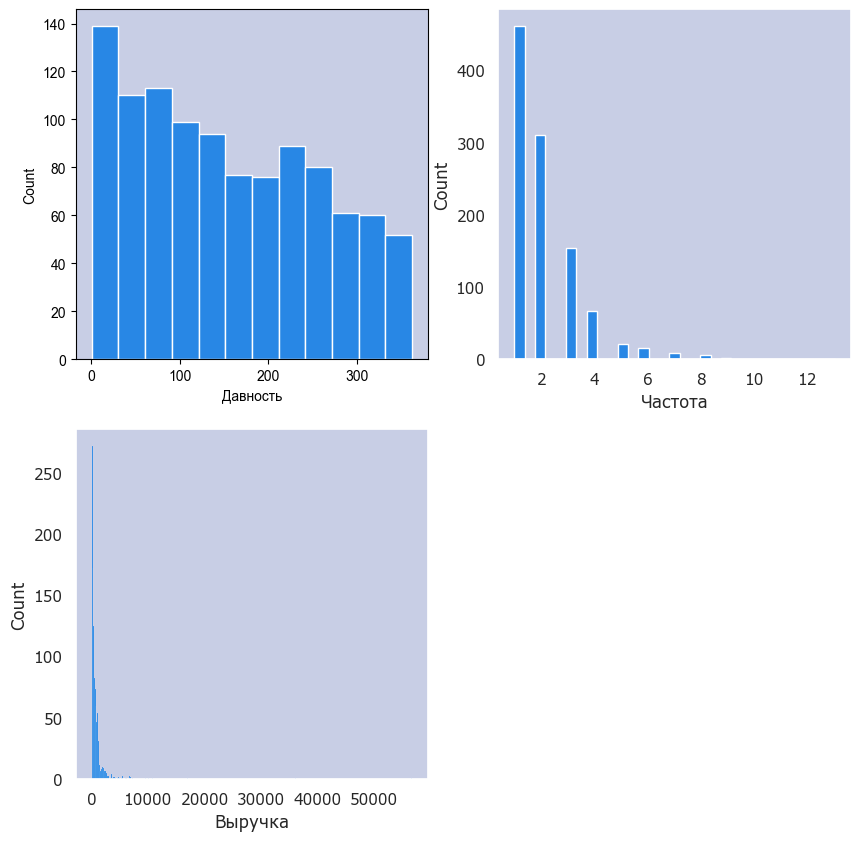

In [13]:
# рассмотрим распределение всех трех признаков

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.set(font='Verdana')
sns.histplot(data=data_process, x='Давность', color='#0076E6',  alpha=0.8, line_kws={'linewidth': 4, 'color': '4040A6'})
plt.gca().set_facecolor('#C8CEE5')
plt.gca().grid(False)

plt.subplot(2, 2, 2)
sns.set(font='Verdana')
sns.histplot(data=data_process, x='Частота', color='#0076E6',  alpha=0.8, linewidth=1)
plt.gca().set_facecolor('#C8CEE5')
plt.gca().grid(False)


plt.subplot(2, 2, 3)
sns.set(font='Verdana')
sns.histplot(data=data_process, x='Выручка', color='#0076E6',  alpha=0.8, line_kws={'linewidth': 6, 'color': '4040A6'})
plt.gca().set_facecolor('#C8CEE5')
plt.gca().grid(False)

plt.show()

In [14]:
# прологарифмируем данные, чтобы попыться избавиться от положительной ассиметрии

data_process['Давность(лог.)'] = np.where(data_process['Давность'] == 0, 0, np.log(data_process['Давность']))
data_process['Частота(лог.)'] = np.where(data_process['Частота'] == 0, 0,np.log(data_process['Частота']))
data_process['Выручка(лог.)'] = np.where(data_process['Выручка'] == 0, 0,np.log(data_process['Выручка']))

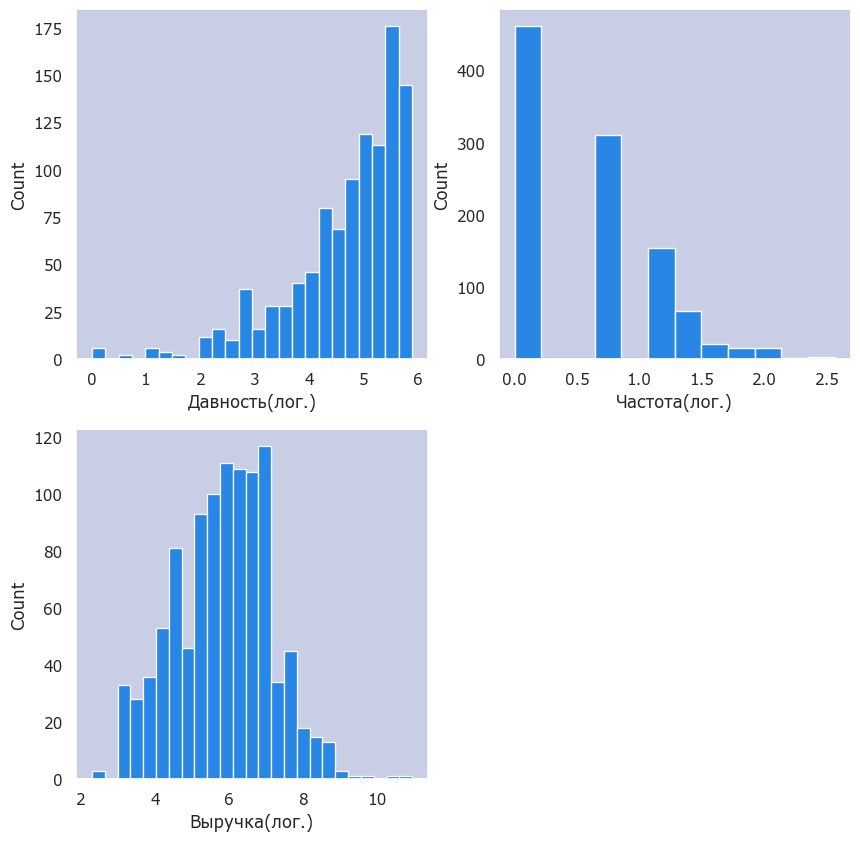

In [15]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.set(font='Verdana')
sns.histplot(data=data_process, x='Давность(лог.)', color='#0076E6',  alpha=0.8, line_kws={'linewidth': 4, 'color': '4040A6'})
plt.gca().set_facecolor('#C8CEE5')
plt.gca().grid(False)

plt.subplot(2, 2, 2)
sns.set(font='Verdana')
sns.histplot(data=data_process, x='Частота(лог.)', color='#0076E6',  alpha=0.8, linewidth=1)
plt.gca().set_facecolor('#C8CEE5')
plt.gca().grid(False)


plt.subplot(2, 2, 3)
sns.set(font='Verdana')
sns.histplot(data=data_process, x='Выручка(лог.)', color='#0076E6',  alpha=0.8, line_kws={'linewidth': 6, 'color': '4040A6'})
plt.gca().set_facecolor('#C8CEE5')
plt.gca().grid(False)

plt.show()

In [16]:
# распределим данные по сегментам

r_labels = range(5, 0, -1); f_labels = range(1,6); m_labels = range(1, 6)

r_groups = pd.cut(data_process['Давность(лог.)'], bins=5, labels=r_labels)
f_groups = pd.cut(data_process['Частота(лог.)'], bins=5, labels=f_labels)
m_groups = pd.cut(data_process['Выручка(лог.)'], bins=5, labels=m_labels)

data_process = data_process.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

In [17]:
data_process.head()

,Давность,Частота,Выручка,Давность(лог.),Частота(лог.),Выручка(лог.),R,F,M
ID клиента,,,,,,,,,
10,324,2,150,5.780744,0.693147,5.010635,1,2,2
11,240,2,80,5.480639,0.693147,4.382027,1,2,2
12,274,1,180,5.613128,0.000000,5.192957,1,1,2
13,299,3,710,5.700444,1.098612,6.565265,1,3,3
14,217,1,80,5.379897,0.000000,4.382027,1,1,2


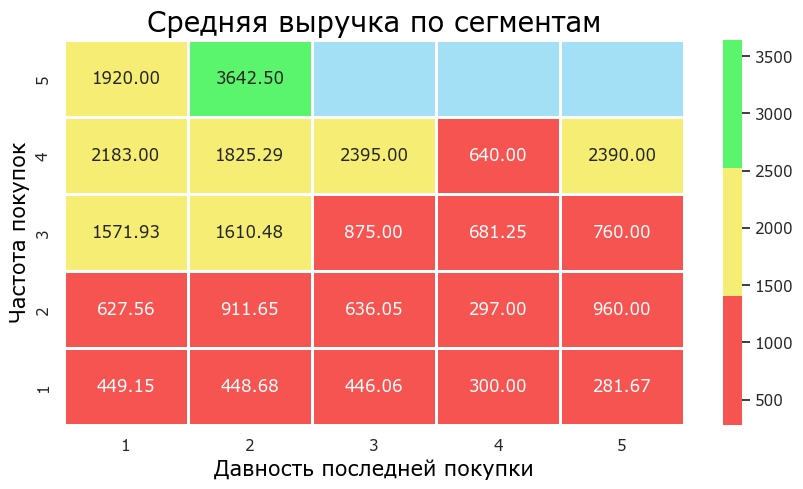

In [18]:
colors = ["#F55451", "#F5ED74", "#5BF56D"]
cmap = sns.color_palette(colors)
rfm_table = data_process.pivot_table(
    index='F',
    columns='R',
    values='Выручка',
    aggfunc=np.mean
)

rfm_table = rfm_table.applymap(float)  # Применяем преобразование к числам с плавающей запятой ко всей сводной таблице
sns.set(font='Verdana')
plt.figure(figsize=(10, 5))
sns.heatmap(rfm_table, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap=cmap)
plt.title('Средняя выручка по сегментам', fontsize=20, color='black')
plt.xlabel('Давность последней покупки', fontsize=15, color='black')
plt.ylabel('Частота покупок', fontsize=15, color='black')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.gca().set_facecolor('#A4E0F5')
plt.gca().grid(False)
plt.show()

Разделим пользователей на подсегменты.

*Просто лучший* - последняя покупка была недавно, заказывает очень часто  
*Потенциальный лоялист* - последняя покупка была недавно, заказывает нечасто  
*Постоянный пользователь* - последняя покупка была относительно недавно, заказывает достаточно часто  
*Засыпающий* - последняя покупка была относительно недавно, но заказывает редко  
*Не можем потерять* - последняя покупка была очень давно, заказывает очень часто  
*В зоне бездействия* - последняя покупка была очень давно, заказывает редко  

In [19]:
segm_map={
    r'[1-2][1-3]' : 'В зоне бездействия',
    r'[1-2][4-5]' : 'Не можем потерять',
    r'[3-4][1-2]' : 'Засыпающий',
    r'[3-4][3-5]' : 'Постоянный пользователь',
    r'5[1-3]' : 'Потенциальный лоялист',
    r'5[4-5]' : 'Просто лучший'
}
data_process['segment'] = data_process['R'].astype(str) + data_process['F'].astype(str)
data_process['segment'] = data_process['segment'].replace(segm_map, regex=True)

In [20]:
rfm_level_agg = data_process.groupby('segment').agg({
    'Давность': ['mean'],
    'Частота': ['mean'],
    'Выручка': ['mean', 'count'],
}).round(1)
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['Дней с последней покупки', 'Кол-во покупок', 'Выручка', 'Кол-во человек']
rfm_level_agg.sort_values(by='Кол-во человек', ascending=False)

,Дней с последней покупки,Кол-во покупок,Выручка,Кол-во человек
segment,,,,
В зоне бездействия,179.4,1.8,765.2,853
Засыпающий,19.7,1.6,509.0,84
Постоянный пользователь,18.1,3.7,1018.8,51
Не можем потерять,146.0,6.6,2139.6,48
Потенциальный лоялист,1.9,2.1,570.0,13
Просто лучший,3.0,6.0,2390.0,1


# Проведем ABC/XYZ анализ для исследования ассортимента компании и приоритезации закупки товаров

In [21]:
# просмотрим таблицы, чтобы объединить интересующие и вычленить нужные данные

display(buyers.head(3))
display(goods.head(3))
display(sellers.head(3))

,ID клиента,Пол,Возраст,Наличие товара в корзине,Избранное,ID товара,Дата покупки,Стоимость,Адрес доставки,Пункт выдачи
0,10,Ж,54,да,да,10,2022-02-02,40,NaN,"Московская область Москва Юрловский проезд, 12"
1,10,Ж,54,да,нет,1052,2022-02-10,110,NaN,"Московская область Москва Юрловский проезд, 12"
2,10,Ж,54,да,да,9059,NaT,380,NaN,NaN


,ID товара,Наименование,Категория,"Цена, руб.",2022-01-01 00:00:00,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00
0,4.0,"Губки ""YORK""5шт MAXI",Бытовая химия и гигиена,50.0,6.0,9.0,9.0,8.0,5.0,9.0,8.0,9.0,5.0,8.0,8.0,13.0
1,6.0,Контейнер СВЧ КВАДРО 0.46л.,Дом и сад,40.0,4.0,5.0,15.0,14.0,18.0,19.0,16.0,20.0,14.0,15.0,8.0,6.0
2,10.0,Контейнер СВЧ ЛАЙТ прямоуг. 0.45л.,Дом и сад,40.0,3.0,5.0,15.0,15.0,20.0,19.0,17.0,15.0,8.0,9.0,8.0,9.0


,ID продавца,Наименование продавца,ID товара,Цена,2022-01-01 00:00:00,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00
0,TM00116,0птТорг Инструмент,776,210,44,23,29,13,30,29,13,17,30,25,39,48
1,TM00116,0птТорг Инструмент,965,40,29,46,35,11,15,20,34,42,21,37,45,35
2,TM00116,0птТорг Инструмент,1021,10,33,41,11,22,30,30,28,12,47,18,21,11


In [22]:
df_general = pd.merge(buyers, goods, on = 'ID товара') # объединяем нужные таблицы
pd.set_option('display.max_columns', None) 
df_general.head(3)

,ID клиента,Пол,Возраст,Наличие товара в корзине,Избранное,ID товара,Дата покупки,Стоимость,Адрес доставки,Пункт выдачи,Наименование,Категория,"Цена, руб.",2022-01-01 00:00:00,2022-02-01 00:00:00,2022-03-01 00:00:00,2022-04-01 00:00:00,2022-05-01 00:00:00,2022-06-01 00:00:00,2022-07-01 00:00:00,2022-08-01 00:00:00,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00
0,10,Ж,54,да,да,10,2022-02-02,40,NaN,"Московская область Москва Юрловский проезд, 12",Контейнер СВЧ ЛАЙТ прямоуг. 0.45л.,Дом и сад,40.0,3.0,5.0,15.0,15.0,20.0,19.0,17.0,15.0,8.0,9.0,8.0,9.0
1,10,Ж,54,да,нет,1052,2022-02-10,110,NaN,"Московская область Москва Юрловский проезд, 12","Ерш д/унитаза ""Капля""",Дом и сад,110.0,5.0,10.0,11.0,15.0,15.0,20.0,18.0,19.0,15.0,11.0,10.0,10.0
2,10,Ж,54,да,да,9059,NaT,380,NaN,NaN,Контейнер д\корма 10л.Dogs М-5394,Товары для животных,380.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,5.0,6.0,1.0,5.0,5.0


In [23]:
df_selected = df_general[['ID клиента', 'Дата покупки', 'Стоимость', 'ID товара', 'Категория', 'Наименование']] 
df_selected.head(3)

,ID клиента,Дата покупки,Стоимость,ID товара,Категория,Наименование
0,10,2022-02-02,40,10,Дом и сад,Контейнер СВЧ ЛАЙТ прямоуг. 0.45л.
1,10,2022-02-10,110,1052,Дом и сад,"Ерш д/унитаза ""Капля"""
2,10,NaT,380,9059,Товары для животных,Контейнер д\корма 10л.Dogs М-5394


In [24]:
# будем работать только с теми товарами, которые были куплены

df_choosed = df_selected[df_selected['Дата покупки'].notnull()]
df_choosed.head(3)

,ID клиента,Дата покупки,Стоимость,ID товара,Категория,Наименование
0,10,2022-02-02,40,10,Дом и сад,Контейнер СВЧ ЛАЙТ прямоуг. 0.45л.
1,10,2022-02-10,110,1052,Дом и сад,"Ерш д/унитаза ""Капля"""
3,11,2022-03-04,40,1555,Электроника,Тройник RUS 6А TOKER 1410 белый


In [25]:
# проверим уникальные категории, чтобы в дальнейшем отразить по ним выручку

df_choosed['Категория'].unique()

array(['Дом и сад', 'Электроника', 'Туризм, рыбалка, охота',
       'Красота и здоровье', 'Бытовая химия и гигиена', 'Детские товары',
       'Спорт и отдых', 'Хобби и творчество', 'Строительство и ремонт',
       'Обувь', 'Товары для животных', 'Одежда', 'Автотовары', 'Мебель',
       'Канцелярские товары', 'Дом и Сад'], dtype=object)

In [26]:
# перезапишем категорию 'Дом и Сад' в 'Дом и сад'

df_choosed.loc[df_choosed['Категория'] == 'Дом и Сад', 'Категория'] = 'Дом и сад'
df_choosed['Категория'].unique()

array(['Дом и сад', 'Электроника', 'Туризм, рыбалка, охота',
       'Красота и здоровье', 'Бытовая химия и гигиена', 'Детские товары',
       'Спорт и отдых', 'Хобби и творчество', 'Строительство и ремонт',
       'Обувь', 'Товары для животных', 'Одежда', 'Автотовары', 'Мебель',
       'Канцелярские товары'], dtype=object)

Теперь отразим выручку по категориям относительно кварталов:

In [27]:
df_choosed = df_choosed.groupby(['Категория', df_choosed['Дата покупки'].dt.to_period('Q')])['Стоимость'].sum().unstack()

# переименуем столбцы

df_choosed.columns = ['Q{}'.format(i) for i in range(1, len(df_choosed.columns) + 1)]

In [28]:
df_choosed # просмотрим содержимое таблицы

,Q1,Q2,Q3,Q4
Категория,,,,
Автотовары,37500,29250,24250,17480
Бытовая химия и гигиена,10390,11890,9600,7910
Детские товары,6920,11450,10640,6810
Дом и сад,29470,31220,32090,23980
Канцелярские товары,450,330,1820,390
Красота и здоровье,66790,45410,35550,39440
Мебель,3710,19080,97320,4290
Обувь,2420,480,2550,2350
Одежда,20770,15010,14680,23190


In [29]:
# для проведения ABC анализа найдем: среднее категорий относительно 4 кварталов, долю, которая занимает эта категория
# и долю с накоплением

df_choosed['Среднее'] = df_choosed.mean(axis=1) # найдем среднее значение за 4 квартала по категориям
df_choosed['Процент'] = (df_choosed['Среднее']/df_choosed['Среднее'].sum())*100 # найдем долю от общего числа
df_choosed['С накоплением'] = df_choosed['Процент'].cumsum() # посчитаем долю с накоплением
df_choosed

,Q1,Q2,Q3,Q4,Среднее,Процент,С накоплением
Категория,,,,,,,
Автотовары,37500,29250,24250,17480,27120.0,12.614394,12.614394
Бытовая химия и гигиена,10390,11890,9600,7910,9947.5,4.626906,17.241299
Детские товары,6920,11450,10640,6810,8955.0,4.165262,21.406561
Дом и сад,29470,31220,32090,23980,29190.0,13.577218,34.983779
Канцелярские товары,450,330,1820,390,747.5,0.347687,35.331465
Красота и здоровье,66790,45410,35550,39440,46797.5,21.767038,57.098503
Мебель,3710,19080,97320,4290,31100.0,14.465621,71.564124
Обувь,2420,480,2550,2350,1950.0,0.907008,72.471133
Одежда,20770,15010,14680,23190,18412.5,8.564252,81.035385


Последний столбец отражает, в какую группу попадет категория. Пусть в группу А будут попадать позиции с показателем до 80%, в группу B будут попадать позиции с показателем от 80% до 95%, а в группу C будут попадать позиции с показателем от 95%.  

**А** - наиболее ценные позиции, обеспечивающие 80% продаж;  
**B** - промежуточные позиции, которое делают 15% продаж;  
**C** - наименее ценные позиции, дающие 5% продаж.   

In [30]:
df_choosed['ABC'] = pd.cut(df_choosed['С накоплением'], bins=[-1, 80, 95, 101], labels=['A', 'B', 'C'])
df_choosed.head()

,Q1,Q2,Q3,Q4,Среднее,Процент,С накоплением,ABC
Категория,,,,,,,,
Автотовары,37500,29250,24250,17480,27120.0,12.614394,12.614394,A
Бытовая химия и гигиена,10390,11890,9600,7910,9947.5,4.626906,17.241299,A
Детские товары,6920,11450,10640,6810,8955.0,4.165262,21.406561,A
Дом и сад,29470,31220,32090,23980,29190.0,13.577218,34.983779,A
Канцелярские товары,450,330,1820,390,747.5,0.347687,35.331465,A


In [31]:
# для проведения XYZ-анализа посчитаем стандартное отклонение и коэффициент вариации

df_choosed['Стандартное отклонение'] = df_choosed[['Q1', 'Q2', 'Q3', 'Q4']].std(axis = 1)
df_choosed['Коэффициент вариации']=(df_choosed['Стандартное отклонение']/df_choosed['Среднее'])*100

In [32]:
df_choosed.head()

,Q1,Q2,Q3,Q4,Среднее,Процент,С накоплением,ABC,Стандартное отклонение,Коэффициент вариации
Категория,,,,,,,,,,
Автотовары,37500,29250,24250,17480,27120.0,12.614394,12.614394,A,8435.002470,31.102516
Бытовая химия и гигиена,10390,11890,9600,7910,9947.5,4.626906,17.241299,A,1657.435268,16.661827
Детские товары,6920,11450,10640,6810,8955.0,4.165262,21.406561,A,2436.288160,27.205898
Дом и сад,29470,31220,32090,23980,29190.0,13.577218,34.983779,A,3640.210617,12.470746
Канцелярские товары,450,330,1820,390,747.5,0.347687,35.331465,A,716.676357,95.876436


Коэфффициент вариации отражает, в какую группу попадет категория товара. X - позиции, с коэффициентом до 10%, Y - позиции с коэффициентом от 10% до 25%, Z - от 25% 

**X** - позиции с устойчивым спросом  
**Y** - позиции с непостоянным спросом  
**Z** - позиции с случайным спросом 

In [33]:
df_choosed['XYZ'] = pd.cut(df_choosed['Коэффициент вариации'], bins=[-1, 10, 25, 1000], labels=['X', 'Y', 'Z'])
df_choosed['XYZ'].value_counts() # проверим, сколько категорий находится в каждой группе

XYZ
Z    11
Y     4
X     0
Name: count, dtype: int64

In [34]:
# объединим группы для сегментации

df_choosed['Итог'] = df_choosed['ABC'].astype(str).str.cat(df_choosed['XYZ'].astype(str), sep='')

In [35]:
df_choosed

,Q1,Q2,Q3,Q4,Среднее,Процент,С накоплением,ABC,Стандартное отклонение,Коэффициент вариации,XYZ,Итог
Категория,,,,,,,,,,,,
Автотовары,37500,29250,24250,17480,27120.0,12.614394,12.614394,A,8435.002470,31.102516,Z,AZ
Бытовая химия и гигиена,10390,11890,9600,7910,9947.5,4.626906,17.241299,A,1657.435268,16.661827,Y,AY
Детские товары,6920,11450,10640,6810,8955.0,4.165262,21.406561,A,2436.288160,27.205898,Z,AZ
Дом и сад,29470,31220,32090,23980,29190.0,13.577218,34.983779,A,3640.210617,12.470746,Y,AY
Канцелярские товары,450,330,1820,390,747.5,0.347687,35.331465,A,716.676357,95.876436,Z,AZ
Красота и здоровье,66790,45410,35550,39440,46797.5,21.767038,57.098503,A,13931.550225,29.769860,Z,AZ
Мебель,3710,19080,97320,4290,31100.0,14.465621,71.564124,A,44715.981483,143.781291,Z,AZ
Обувь,2420,480,2550,2350,1950.0,0.907008,72.471133,A,983.497161,50.435752,Z,AZ
Одежда,20770,15010,14680,23190,18412.5,8.564252,81.035385,B,4238.351684,23.018882,Y,BY


In [36]:
# подведем итоги по каждой категории

results = df_choosed['Итог']
results

Категория
Автотовары                 AZ
Бытовая химия и гигиена    AY
Детские товары             AZ
Дом и сад                  AY
Канцелярские товары        AZ
Красота и здоровье         AZ
Мебель                     AZ
Обувь                      AZ
Одежда                     BY
Спорт и отдых              BZ
Строительство и ремонт     BZ
Товары для животных        BY
Туризм, рыбалка, охота     BZ
Хобби и творчество         CZ
Электроника                CZ
Name: Итог, dtype: object

In [37]:
results.value_counts() # просмотрим группы и кол-во категорий в ним

Итог
AZ    6
BZ    3
AY    2
BY    2
CZ    2
Name: count, dtype: int64

**Поведем итоги:**

Категории, попавшие в AY, продолжаем удерживать на том же уровне и развивать.  
Категории, попавшие в AZ, BY, BZ, CY, требуют дополнительного анализа.  
Категории, попавшие в CZ, можно отнести в "стоп".  